In [ ]:
# STEP 1: Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# STEP 2: Load dataset
df = pd.read_csv('emotions_updated.csv')  
print("Original class distribution:\n", df['Emotion'].value_counts())

# STEP 3: Label Encoding
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Emotion'])

# STEP 4: Tokenize Text
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['Text'])
sequences = tokenizer.texts_to_sequences(df['Text'])

max_len = 70
X = pad_sequences(sequences, maxlen=max_len, padding='post')
y = to_categorical(df['label'])

# STEP 5: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# STEP 6: Load GloVe embeddings
embedding_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

embedding_dim = 100
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# STEP 7: Build Model
model = Sequential([
    Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
              input_length=max_len, trainable=False),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dense(y.shape[1], activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# STEP 8: Compute Class Weights
classes = np.unique(df['label'])
weights = compute_class_weight(class_weight='balanced', classes=classes, y=df['label'])
class_weights = dict(zip(classes, weights))
print("\nClass Weights:", class_weights)

# STEP 9: Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# STEP 10: Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop]
)


Original class distribution:
 Emotion
happy        7029
sad          6265
angry        2993
fearful      2652
love         1641
surprised     879
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │     1,926,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,926,000 (7.35 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,926,000 (7.35 MB)


Class Weights: {np.int64(0): np.float64(1.194954894754427), np.int64(1): np.float64(1.348604826546003), np.int64(2): np.float64(0.5088206003698962), np.int64(3): np.float64(2.179463741620963), np.int64(4): np.float64(0.5708699122106944), np.int64(5): np.float64(4.068828213879408)}
Epoch 1/20
537/537 ━━━━━━━━━━━━━━━━━━━━ 90s 151ms/step - accuracy: 0.2038 - loss: 1.6768 - val_accuracy: 0.5610 - val_loss: 1.1549
Epoch 2/20
537/537 ━━━━━━━━━━━━━━━━━━━━ 80s 149ms/step - accuracy: 0.6099 - loss: 0.9488 - val_accuracy: 0.7404 - val_loss: 0.7506
Epoch 3/20
537/537 ━━━━━━━━━━━━━━━━━━━━ 82s 149ms/step - accuracy: 0.7652 - loss: 0.5942 - val_accuracy: 0.8115 - val_loss: 0.5271
Epoch 4/20
537/537 ━━━━━━━━━━━━━━━━━━━━ 82s 149ms/step - accuracy: 0.8261 - loss: 0.4216 - val_accuracy: 0.8439 - val_loss: 0.4434
Epoch 5/20
537/537 ━━━━━━━━━━━━━━━━━━━━ 88s 160ms/step - accuracy: 0.8533 - loss: 0.3459 - val_accuracy: 0.8721 - val_loss: 0.3522
Epoch 6/20
537/537 ━━━━━━━━━━━━━━━━━━━━ 141s 157ms/step - accu

135/135 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - accuracy: 0.9108 - loss: 0.2410

✅ Test Accuracy: 0.9112
135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step

Classification Report:
              precision    recall  f1-score   support

       angry       0.90      0.92      0.91       617
     fearful       0.84      0.93      0.88       531
       happy       0.96      0.89      0.92      1381
        love       0.78      0.94      0.85       318
         sad       0.95      0.93      0.94      1277
   surprised       0.79      0.75      0.77       168

    accuracy                           0.91      4292
   macro avg       0.87      0.89      0.88      4292
weighted avg       0.92      0.91      0.91      4292



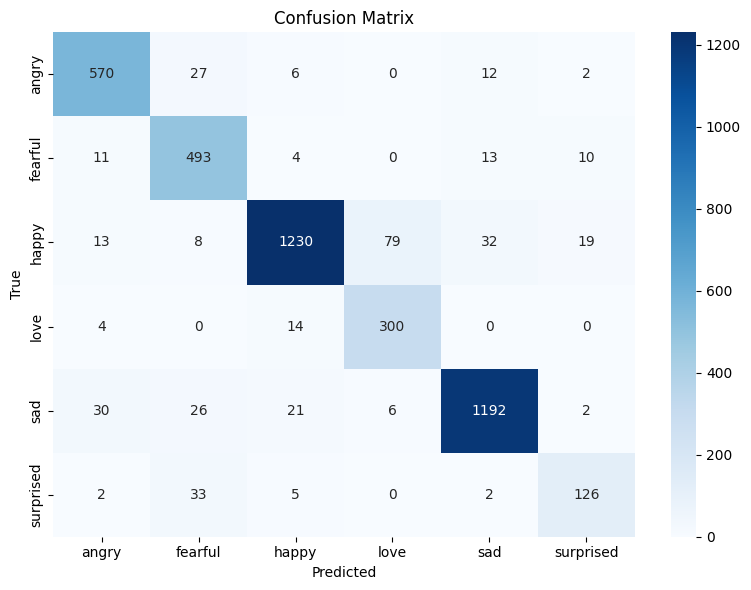


Sample Prediction:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Text: I am feeling very disappointed. → Emotion: sad


In [63]:

# STEP 11: Evaluate
loss, acc = model.evaluate(X_test, y_test)
print(f"\n✅ Test Accuracy: {acc:.4f}")

# STEP 12: Classification Report
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# STEP 13: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# STEP 14: Predict Function
def predict_emotion(text):
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=max_len, padding='post')
    pred = model.predict(padded)
    emotion = label_encoder.inverse_transform([np.argmax(pred)])
    return emotion[0]

# Try predictions
print("\nSample Prediction:")
sample = "I am feeling very disappointed."
print(f"Text: {sample} → Emotion: {predict_emotion(sample)}")


In [75]:
model.save("emotion_lstm_glove_model.h5")


In [76]:
import pickle

with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
